In [10]:
from copy import deepcopy
from subpred.util import load_df
import obonet
import networkx as nx

In [11]:
def get_protein_dataset(
    datasets_folder_path: str,
    organism_ids: set = set(),
    evidence_at_protein_level=True,
    reviewed: bool = True,
):
    df_uniprot = load_df("uniprot", datasets_folder_path)
    if organism_ids:
        df_uniprot = df_uniprot[df_uniprot.organism_id.isin(organism_ids)]
    if evidence_at_protein_level:
        df_uniprot = df_uniprot[df_uniprot.protein_existence == 1]
    if reviewed:
        df_uniprot = df_uniprot[df_uniprot.reviewed]
    return df_uniprot

In [12]:
def get_go_annotations(
    datasets_folder_path: str, proteins: set, include_iea: bool = True
):
    df_goa_uniprot = load_df("go", datasets_folder_path)
    df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.Uniprot.isin(proteins)]
    if not include_iea:
        df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.evidence_code != "IEA"]
    df_goa_uniprot = df_goa_uniprot.reset_index(drop=True)
    return df_goa_uniprot

In [13]:
def add_ancestors(df_uniprot_goa, graph_go):
    df_uniprot_goa = df_uniprot_goa.assign(
        ancestors=[
            nx.descendants(graph_go, go_id) | {go_id} for go_id in df_uniprot_goa.go_id
        ]
    )

    df_uniprot_goa = (
        df_uniprot_goa.explode("ancestors")
        .drop("go_id", axis=1)
        .rename(columns={"ancestors": "go_id"})
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return df_uniprot_goa

In [14]:
# Funtion parameters TODO create function
organism_ids={83333}
datasets_folder_path="data/datasets"
go_obo_path="data/raw/ontologies/go.obo"
chebi_obo_path="data/raw/ontologies/chebi.obo"

In [15]:
df_uniprot = get_protein_dataset(
    datasets_folder_path=datasets_folder_path,
    organism_ids=organism_ids,
    evidence_at_protein_level=True,
    reviewed=True,
)

## Filtering GO graph

In [16]:
# Read go graph
graph_go = obonet.read_obo(go_obo_path, ignore_obsolete=True)
## Filter graph by organism

df_uniprot_goa = get_go_annotations(
    datasets_folder_path=datasets_folder_path,
    proteins=set(df_uniprot.index.tolist()),
    include_iea=True,
)
## Add ancestors to goa, i.e. more abstract terms
df_uniprot_goa = add_ancestors(df_uniprot_goa=df_uniprot_goa, graph_go=graph_go)
print(len(graph_go.nodes()))
graph_go = graph_go.subgraph(nodes=set(df_uniprot_goa.go_id.unique()))
print(len(graph_go.nodes()))

## Filter graph by aspect/namespace
graph_go = graph_go.subgraph(
    nodes=[
        node
        for node, data in graph_go.nodes(data=True)
        if data["namespace"] == "molecular_function"
    ]
)
print(len(graph_go.nodes()))

## Filter graph by relations
graph_go = graph_go.edge_subgraph(
    edges={edge for edge in graph_go.edges(keys=True) if edge[2] == "is_a"}
)
print(len(graph_go.nodes()))

## Filter graph by function
go_name_to_id = {data["name"]: id for id, data in graph_go.nodes(data=True)}
tmtp_ancestors = nx.ancestors(
    graph_go, go_name_to_id["transmembrane transporter activity"]
)
graph_go = graph_go.subgraph(
    tmtp_ancestors | {go_name_to_id["transmembrane transporter activity"]}
)
print(len(graph_go.nodes()))

## Filter goa dataset by go terms in filtered graph
df_uniprot_goa = df_uniprot_goa[df_uniprot_goa.go_id.isin(graph_go.nodes())]

43248
5826
2424
2424
383


## Filtering Chebi data

In [148]:

# Read chebi ontology
graph_chebi = obonet.read_obo(chebi_obo_path, ignore_obsolete=True)
chebi_id_to_name = {id: data["name"] for id, data in graph_chebi.nodes(data=True)}
chebi_name_to_id = {y:x for x,y in chebi_id_to_name.items()}
## Filter by manually annotated entries
print(len(graph_chebi.nodes()))
graph_chebi = graph_chebi.subgraph([x for x, data in graph_chebi.nodes(data=True) if "3_STAR" in data["subset"]])
print(len(graph_chebi.nodes()))

## Filter by substrates

## Add ancestors to get full graph


164519
60547


162909

In [133]:
# Annotate with chebi primary input substrates
## Read go-chebi mapping
df_go_to_chebi = load_df("go_chebi", datasets_folder_path)

## Filter for primary input substrates:
df_go_to_chebi = (
    df_go_to_chebi[df_go_to_chebi.relation == "has_primary_input"]
    .reset_index(drop=True)
    .drop("relation", axis=1)
)
## Filter by go terms in graph:
print(df_go_to_chebi.shape[0])
# TODO update the go terms?
df_go_to_chebi = df_go_to_chebi[df_go_to_chebi.go_id.isin(graph_go.nodes())].reset_index(drop=True)
print(df_go_to_chebi.shape[0])

substrates_set = set(df_go_to_chebi.chebi_term.unique())
print(substrates_set)
# dict_go_id_to_chebi_ids = (
#     df_go_to_chebi_primary[["go_id", "chebi_id"]]
#     .groupby("go_id")
#     .apply(lambda x: set(x.chebi_id))
#     .to_dict()
# )


1996
335
{'alkanesulfonate oxoanion', 'xanthosine', 'lead ion', 'L-leucine zwitterion', 'L-proline zwitterion', 'lysinium(1+)', 'nickel cation', 'D-alanine zwitterion', 'L-phenylalanine zwitterion', 'formate', 'L-ornithinium(1+)', 'sulfur-containing amino acid', 'iron chelate', 'nitrite', 'glucose', 'zinc cation', 'organic cation', 'beta-alanine zwitterion', 'xanthine', 'sialic acid', 'glycine zwitterion', 'phosphate', 'branched-chain amino acid', 'purine nucleoside', 'monocarboxylic acid', 'nitrate', 'potassium(1+)', 'inorganic anion', 'dicarboxylic acid', 'D-glucose 6-phosphate', 'mannitol', 'ammonium', 'molybdate', 'purine nucleobase', 'manganese cation', 'lactose', 'tripeptide', '2-dehydro-3-deoxy-D-gluconate', 'arsenite(1-)', 'copper(1+)', 'L-idonate', 'pyrimidine nucleoside', 'galactitol', 'iron(III) hydroxamate', 'L-arabinose', 'water', 'peptidoglycan', 'D-methionine zwitterion', 'D-galactonate', 'agmatinium(2+)', 'oligopeptide', 'transition element cation', 'proline', 'inorgani

In [138]:
# TODO add ancestors to chebi graph?
df_go_to_chebi


[chebi_id_to_name[x] for x in nx.descendants(graph_chebi,"CHEBI:28163")]

['oxygen atom',
 'carbon oxoacid',
 'acceptor',
 'physiological role',
 'bacterial metabolite',
 'gas molecular entity',
 'group',
 'anion',
 'carbonyl compound',
 'human metabolite',
 'carbonyl group',
 'reagent',
 'Lewis base',
 'main group element atom',
 'heteroorganic entity',
 'p-block molecular entity',
 'carbamate',
 'polyatomic ion',
 'oxide',
 'biological role',
 'monovalent inorganic anion',
 'carbon atom',
 'acid',
 'azanide',
 'EC 3.5.1.* (non-peptide linear amide C-N hydrolase) inhibitor',
 'amide',
 'main group molecular entity',
 'fermion',
 'iron chelate',
 'carbamoyl group',
 'aetiopathogenetic role',
 'organic acid',
 'p-block element atom',
 'hydroxamic acid anion',
 'transition element atom',
 'iron group element atom',
 'chemical entity',
 'hydrogen atom',
 'onium compound',
 'organic ion',
 'refrigerant',
 'iron coordination entity',
 'lepton',
 'animal metabolite',
 'baryon',
 'nuclear particle',
 'Bronsted acid',
 'hydridonitrate(2-)',
 'Bronsted base',
 'micro

## Mapping Uniprot to Chebi

In [21]:
df_uniprot_go_chebi = df_uniprot_goa[["Uniprot", "go_id"]].merge(
    df_go_to_chebi, how="inner", on="go_id"
)

df_uniprot_go_chebi

# TODO update go terms, chebi ids?

# TODO parameters
# TODO refactor


,Uniprot,go_id,chebi_id,chebi_term
0,A5A627,GO:0008509,CHEBI:23905,monoatomic anion
1,A5A627,GO:0008509,CHEBI:23905,monoatomic anion
2,P0AA80,GO:0008509,CHEBI:23905,monoatomic anion
3,P0AFZ7,GO:0008509,CHEBI:23905,monoatomic anion
4,P23849,GO:0008509,CHEBI:23905,monoatomic anion
...,...,...,...,...
4088,P76352,GO:0044610,CHEBI:58210,FMN(3-)
4089,Q46821,GO:0015143,CHEBI:46819,urate salt
4090,Q59385,GO:0043682,CHEBI:29036,copper(2+)
4091,Q59385,GO:0140581,CHEBI:49552,copper(1+)


In [150]:
# TODO some could get lost because of conversions to old go terms or chebi ids.

df_uniprot_go_chebi.Uniprot.unique().shape[0]

333

## Calculating pairwise overlaps for substrates with more then n substrates

In [110]:
import pandas as pd

dict_chebi_to_uniprot = df_uniprot_go_chebi[["chebi_id", "Uniprot"]].groupby("chebi_id").apply(lambda x: set(x.Uniprot)).to_dict()
dict_chebi_to_uniprot_filtered = {x:y for x,y in dict_chebi_to_uniprot.items() if len(y) > 19}

## Calculate protein annotation overlaps for go and chebi, create plot
sorted_chebi_order = [
    tup[0]
    for tup in sorted(
        [
            (chebi_id, len(proteins))
            for chebi_id, proteins in dict_chebi_to_uniprot_filtered.items()
        ],
        key=lambda x: x[1],
        reverse=True,
    )
]

substrates = sorted_chebi_order
df_substrate_overlaps = pd.DataFrame(0, columns=substrates, index=substrates)

for chebi_id1 in substrates:
    for chebi_id2 in substrates:
        intersection = (
            dict_chebi_to_uniprot_filtered[chebi_id1]
            & dict_chebi_to_uniprot_filtered[chebi_id2]
        )
        overlap = len(intersection)
        df_substrate_overlaps.at[chebi_id1, chebi_id2] = overlap

df_substrate_overlaps.columns = df_substrate_overlaps.columns.map(chebi_id_to_name)
df_substrate_overlaps.index = df_substrate_overlaps.index.map(chebi_id_to_name)

df_substrate_overlaps

,monoatomic ion,monoatomic cation,inorganic cation,organic anion,organic acid,carboxylic acid anion,carbohydrate,proton,chemical entity,amino acid,metal cation,amide,peptide,L-alpha-amino acid zwitterion,carbohydrate derivative,monosaccharide,monocarboxylic acid,inorganic anion
monoatomic ion,121,102,94,21,21,21,19,62,56,10,43,10,8,4,5,7,7,7
monoatomic cation,102,102,94,19,19,19,17,62,56,9,43,9,7,3,5,7,6,5
inorganic cation,94,94,95,18,18,18,16,62,50,9,43,9,7,3,5,7,6,5
organic anion,21,19,18,90,82,80,7,14,17,46,6,6,4,29,6,2,22,3
organic acid,21,19,18,82,82,80,7,14,17,46,6,4,2,29,1,2,22,2
carboxylic acid anion,21,19,18,80,80,80,7,14,17,46,6,4,2,29,1,2,22,2
carbohydrate,19,17,16,7,7,7,69,14,17,0,2,0,0,0,6,25,4,0
proton,62,62,62,14,14,14,14,62,41,6,11,5,5,2,3,6,6,3
chemical entity,56,56,50,17,17,17,17,41,56,8,16,5,4,3,5,7,6,4
amino acid,10,9,9,46,46,46,0,6,8,46,4,2,1,29,0,0,1,1


## Plots

<AxesSubplot:title={'center':'Substrate molecular species overlaps in E. coli for substrates with 20 or more proteins'}>

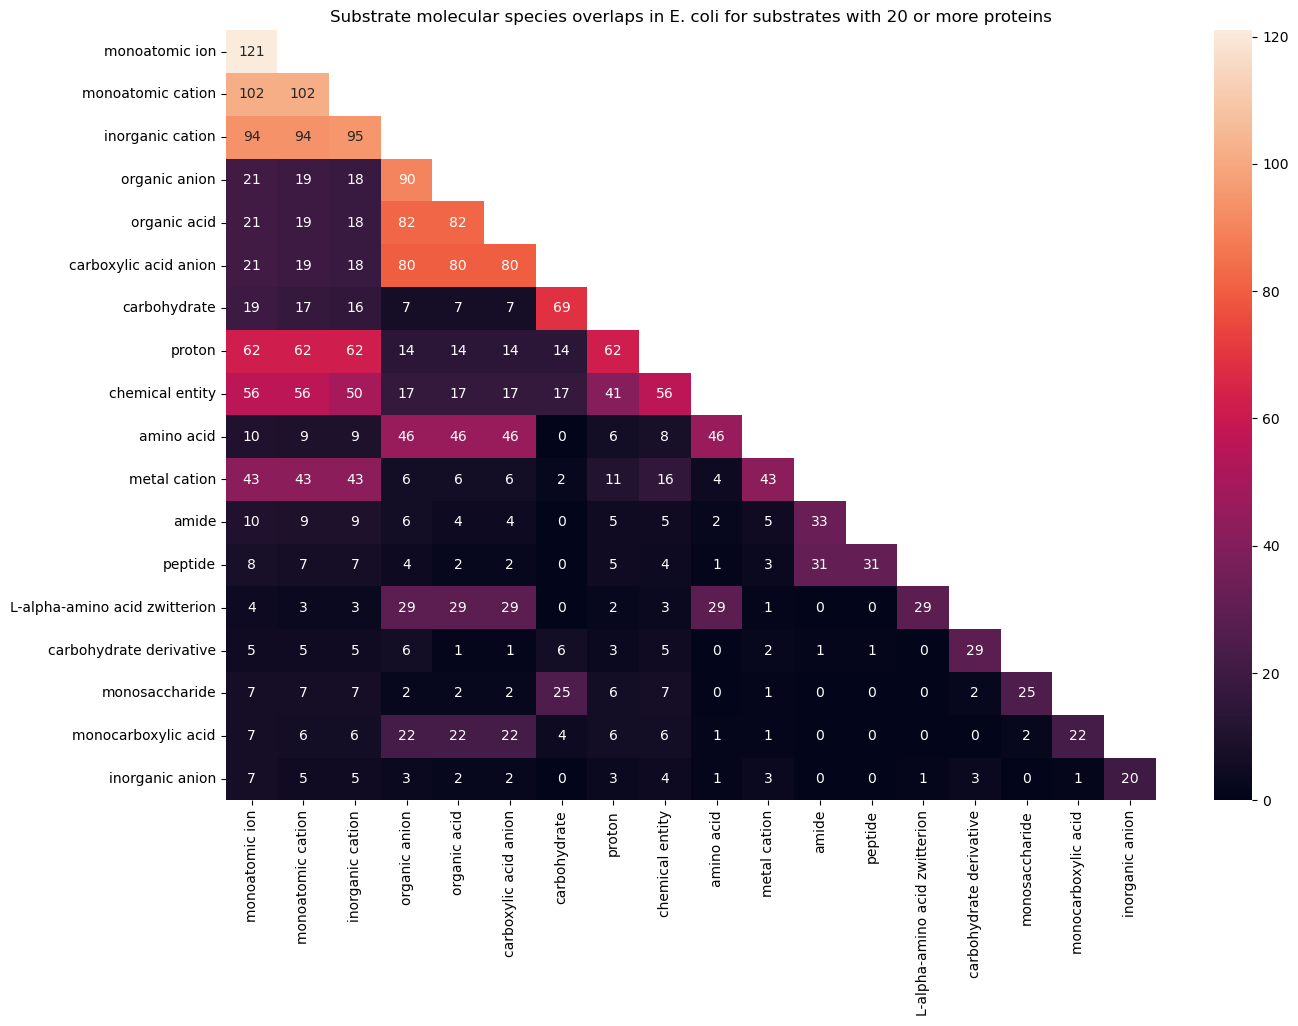

In [117]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,10))
plt.title("Substrate molecular species overlaps in E. coli for substrates with 20 or more proteins")

triangle=True
mask = None
if triangle:
     mask = np.triu(np.ones_like(df_substrate_overlaps),k=1)
sns.heatmap(df_substrate_overlaps, annot=True,fmt=".0f", mask = mask)

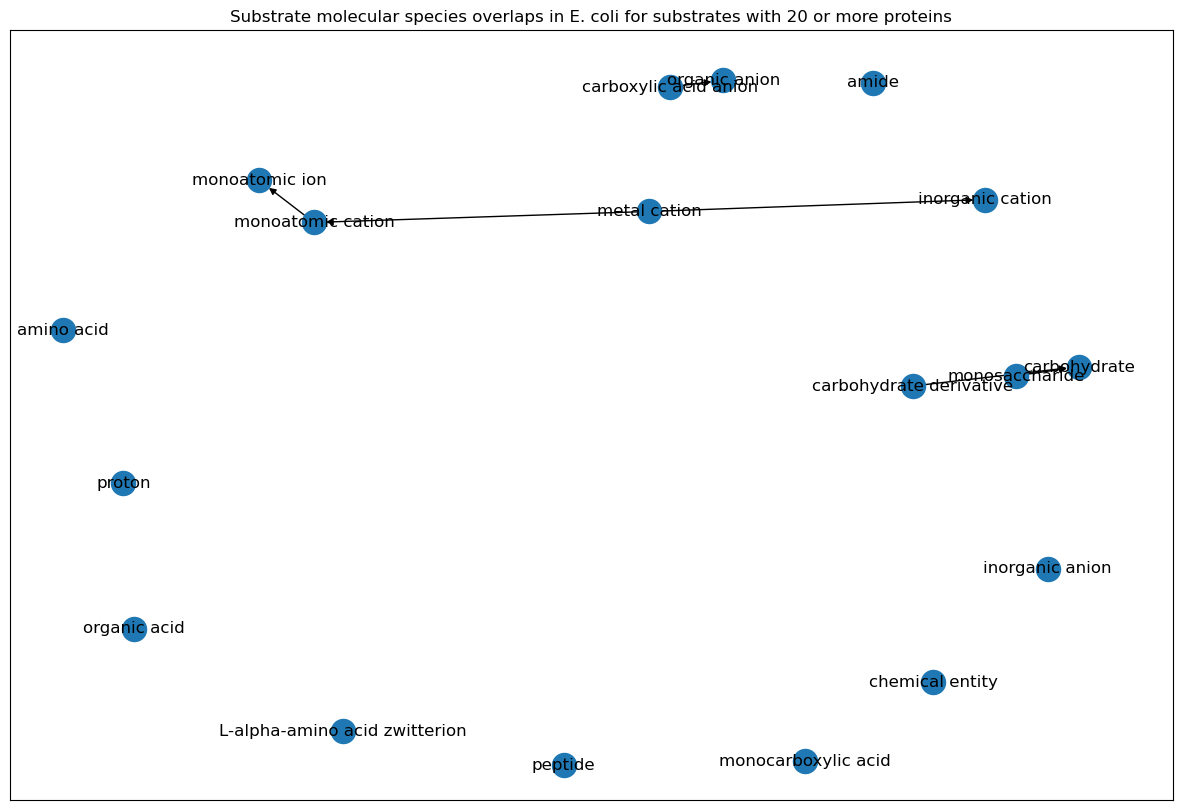

In [130]:
graph_chebi_filtered = graph_chebi.subgraph(dict_chebi_to_uniprot_filtered.keys())

import networkx as nx


plt.figure(figsize=(15, 10))
plt.title(
    "Relations between molecular species in E. coli for substrates with 20 or more proteins"
)


nx.draw_networkx(
    graph_chebi_filtered,
    labels={node: name for node, name in graph_chebi_filtered.nodes(data="name")},
)
# nx.draw_networkx_labels(graph_chebi_filtered)

In [ ]:
# Stats and Plots, options for filtering

## create overlap heatmap between substrates

### merge uniprot to go with go to chebi
